## Treatment T10 Preparation

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

RND_SEED = 5
np.random.seed = RND_SEED


df = pd.read_excel("../data/t00/data.xls")
df_full = df.copy()
#Drop 'protected' features
drop_cols = ['prop', 'other_prop', 'other_resp']
df = df[[col for col in df.columns if col not in drop_cols]]

## comment/uncomment for shuffling
#df = df.sample(frac=1.0)
TEST_SIZE = 50
df_base = df.copy()

df_train = df.head(df.shape[0] - TEST_SIZE)
df_test = df.tail(TEST_SIZE)


df_full = pd.read_excel("../data/t00/data.xls")
df_min = df_full.min()
df_min.values[:] = 0
df_max = df_full.max()
df_max["Honesty_Humility"] = 5.0
df_max["Extraversion"] = 5.0
df_max["Agreeableness"] = 5.0
df_max["cells"] = 50
df_max["selfish"] = 60
df_max["min_offer"] = 200
df_max["prop"] = 200
df_max["other_resp"] = 200
df_max["other_prop"] = 200
df_max["count_effort"] = 20


df.head()
df_max

prop                   200.0
other_resp             200.0
other_prop             200.0
time_spent_risk     152000.0
cells                   50.0
selfish                 60.0
time_spent_prop     269000.0
count_effort            20.0
Honesty_Humility         5.0
Extraversion             5.0
Agreeableness            5.0
min_offer              200.0
dtype: float64

## Determine significant features

**Feature importance permutation**

In [2]:
from core.utils.preprocessing import df_to_xy, df_to_xydf
from core.models import AcceptanceModel, ClusterExtModel
from core.utils.benchmark import process_model, process_benchmark_cv
from mlxtend.evaluate import feature_importance_permutation

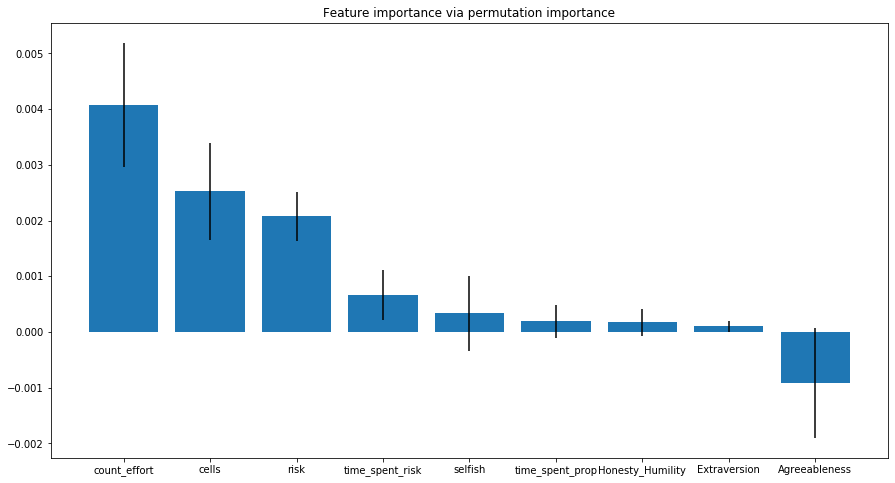

In [14]:
from core.utils.preprocessing import df_to_xy, df_to_xydf
from core.models.metrics import avg_gain_ratio

NB_REPETITIONS = 5

imp_vals = None
imp_all = None
for _ in range(NB_REPETITIONS):
    df_x, df_y = df_to_xydf(df_train.sample(frac=1.0, random_state=RND_SEED), fuse_risk=True)
    model = ClusterExtModel(base_model="affinity")
    split = int(0.6 * df_x.shape[0])
    model.fit(df_x.values[:split], df_y.values.ravel()[:split])

    step_imp_vals, step_imp_all = feature_importance_permutation(
        predict_method=model.predict, 
        X=df_x.values[split:],
        y=df_y.values.ravel()[split:],
        metric=avg_gain_ratio,
        num_rounds=3,
        seed=None)
    if imp_vals is None:
        imp_vals = step_imp_vals
        imp_all = step_imp_all
    else:
        imp_vals += step_imp_vals
        imp_all += step_imp_all


imp_all /= NB_REPETITIONS
imp_vals /= NB_REPETITIONS
std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure(figsize=(15, 8))
plt.title("Feature importance via permutation importance")
plt.bar(df_x.columns[indices], imp_vals[indices],
        yerr=std[indices],)
plt.show()



## Generate data for the survey

**Save the model and model infos**

In [4]:
from core.utils.pipeline import train_and_save
cols = ['time_spent_risk', 'cells', 'selfish', 'risk',
            'count_effort', 'Honesty_Humility', 'Extraversion', 'Agreeableness'
        ]
results = []
for col in cols:
    model = ClusterExtModel(base_model="affinity")
    tm, infos = train_and_save("../data/t00", "../data/t10", model=model, shuffle=True, random_state=RND_SEED, top_columns=[col])
    results.append(infos)
    infos['col'] = col
    
result_df = pd.DataFrame(data=results)
result_df.index = result_df['col'].values
result_df = result_df[['acc', 'val_acc', 'unique_preds']]

result_df


,acc,val_acc,unique_preds
time_spent_risk,0.772745,0.783298,"[100.0, 105.0, 110.0]"
cells,0.627428,0.691755,"[50.0, 90.0, 100.0, 105.0]"
selfish,0.592354,0.792099,[100.0]
risk,0.755332,0.781097,"[100.0, 105.0, 110.0]"
count_effort,0.665986,0.531495,"[50.0, 80.0, 90.0, 100.0, 105.0, 150.0]"
Honesty_Humility,0.733796,0.740863,"[50.0, 80.0, 100.0, 105.0]"
Extraversion,0.744001,0.777797,"[100.0, 105.0]"
Agreeableness,0.749173,0.746237,"[90.0, 95.0, 100.0, 105.0, 150.0]"


In [5]:
model = ClusterExtModel(base_model="meanshift")
top_model, infos = train_and_save("../data/t00", "../data/t00", model=model, shuffle=True, random_state=RND_SEED, top_columns=['risk', 'count_effort', 'Honesty_Humility', 'selfish'])
print("acc:", infos["acc"], "val_acc:", infos["val_acc"], "unique_values:", (infos["unique_preds"]))
top_model.base_model.cluster_centers_
top_model.predict(top_model.base_model.cluster_centers_)

acc: 0.7785426438025053 val_acc: 0.7920986420986419 unique_values: [100.0]


array([100.])

In [6]:
# from sklearn.svm import SVR
# from core.models import AcceptanceModel
# model = AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=2), step=10, zero_one=False)

# top_model, infos = train_and_save("../data/t00", "../data/t00", model=model, shuffle=True, random_state=RND_SEED+0, top_columns=['risk', 'count_effort', 'Honesty_Humility', 'selfish'])
# print("acc:", infos["acc"], "val_acc:", infos["val_acc"], "unique_values:", (infos["unique_preds"]))


In [7]:
# x, y = df_to_xy(df, normalize=True, select_columns=['risk', 'count_effort', 'Honesty_Humility', 'selfish'], df_min=df_min, df_max=df_max)
# x.std(0)

In [8]:

np.unique(top_model.predict(x))

NameError: name 'x' is not defined

In [ ]:
from core.utils.explanation import get_acceptance_probability
offers = np.arange(0, 205, 5)
p_accepted = [get_acceptance_probability(offer, infos["pdf"]) for offer in offers]
pd.DataFrame(data={"offer": offers, "p_accepted": p_accepted}).plot(x="offer", y="p_accepted")

In [ ]:
from core.utils.explanation import get_best_offer_probability
m = np.zeros((len(offers), len(offers)))
for idx_ai, ai_offer in enumerate(offers):
    for idx, offer in enumerate(offers):
        m[idx_ai][idx] = get_best_offer_probability(ai_offer, offer, infos["acc"], infos["train_err_pdf"])

In [ ]:
p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002], "same")
p_best_offer *= infos["acc"] / p_best_offer.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer})
df.plot(x="offer-ai_offer", y="p_best_offer")


In [ ]:
# p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002])
p_best_offer_raw = np.array(infos["train_err_pdf"])
p_best_offer_raw *= (infos["acc"] * 1.0) / p_best_offer_raw.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer - p_best_offer_raw})
df.plot(x="offer-ai_offer", y="p_best_offer")